In [1]:
from glob import glob
from xml.etree import cElementTree as ElementTree
from utility import *
import sys, json, os
from tqdm import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle
%matplotlib inline

In [2]:
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(style="whitegrid")
# sns.set_context("paper")
# sns.set_context("talk")
sns.set_context("poster", font_scale=2.5)
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
xml_files = glob('./analysis/*/*.xml')
# Load pdbs that has resolution less than 3 angstroms
with open("high_quality_pdbs.pickle", "rb") as f:
    valid_pdbs = pickle.load(f)

In [4]:
len(valid_pdbs)

135219

In [5]:
print("Number of xml files: {}".format(len(xml_files)))

Number of xml files: 160662


##### Identify all type of interactions

In [6]:
from collections import defaultdict

In [7]:
interactions = defaultdict(list)

for _file in tqdm_notebook(xml_files):
    # Get the pdbid
    pdbid = os.path.split(_file)[0]
    pdbid = pdbid.split('/')[2]
    if pdbid not in valid_pdbs: continue

    # Parse the xml file
    tree = ElementTree.parse(_file)
    root = tree.getroot()
    xmldict = XmlDictConfig(root)

    #_dict = {}
    if 'bindingsite' in xmldict.keys():
        d = xmldict['bindingsite']
        if 'interactions' in d.keys():
            d = d['interactions']
            _interactions = [i for i in d.keys() if d[i] is not None]
            for i in _interactions:
                interactions[i].append(pdbid)

In [8]:
with open('interactions.pickle', 'wb') as f:
    pickle.dump(interactions, f)

In [9]:
bar_data = []
for k, v in interactions.items():
    bar_data.append([k, len(v)])
    print(f'{k} {len(v)}')

metal_complexes 30010
hydrogen_bonds 72434
water_bridges 44569
salt_bridges 39305
hydrophobic_interactions 32326
pi_stacks 10981
pi_cation_interactions 4402
halogen_bonds 1073


In [10]:
bar_data_df = pd.DataFrame.from_records(bar_data, columns=['interaction', 'count'])
bar_data_df.head(10)

,interaction,count
0,metal_complexes,30010
1,hydrogen_bonds,72434
2,water_bridges,44569
3,salt_bridges,39305
4,hydrophobic_interactions,32326
5,pi_stacks,10981
6,pi_cation_interactions,4402
7,halogen_bonds,1073


[Text(0, 0, 'Metal Complexes'),
 Text(0, 0, 'Hydrogen Bonds'),
 Text(0, 0, 'Water Bridges'),
 Text(0, 0, 'Salt Bridges'),
 Text(0, 0, 'Hydrophobic interactions'),
 Text(0, 0, 'Pi Stacks'),
 Text(0, 0, 'Pi Cation Interactions'),
 Text(0, 0, 'Halogen Bonds')]

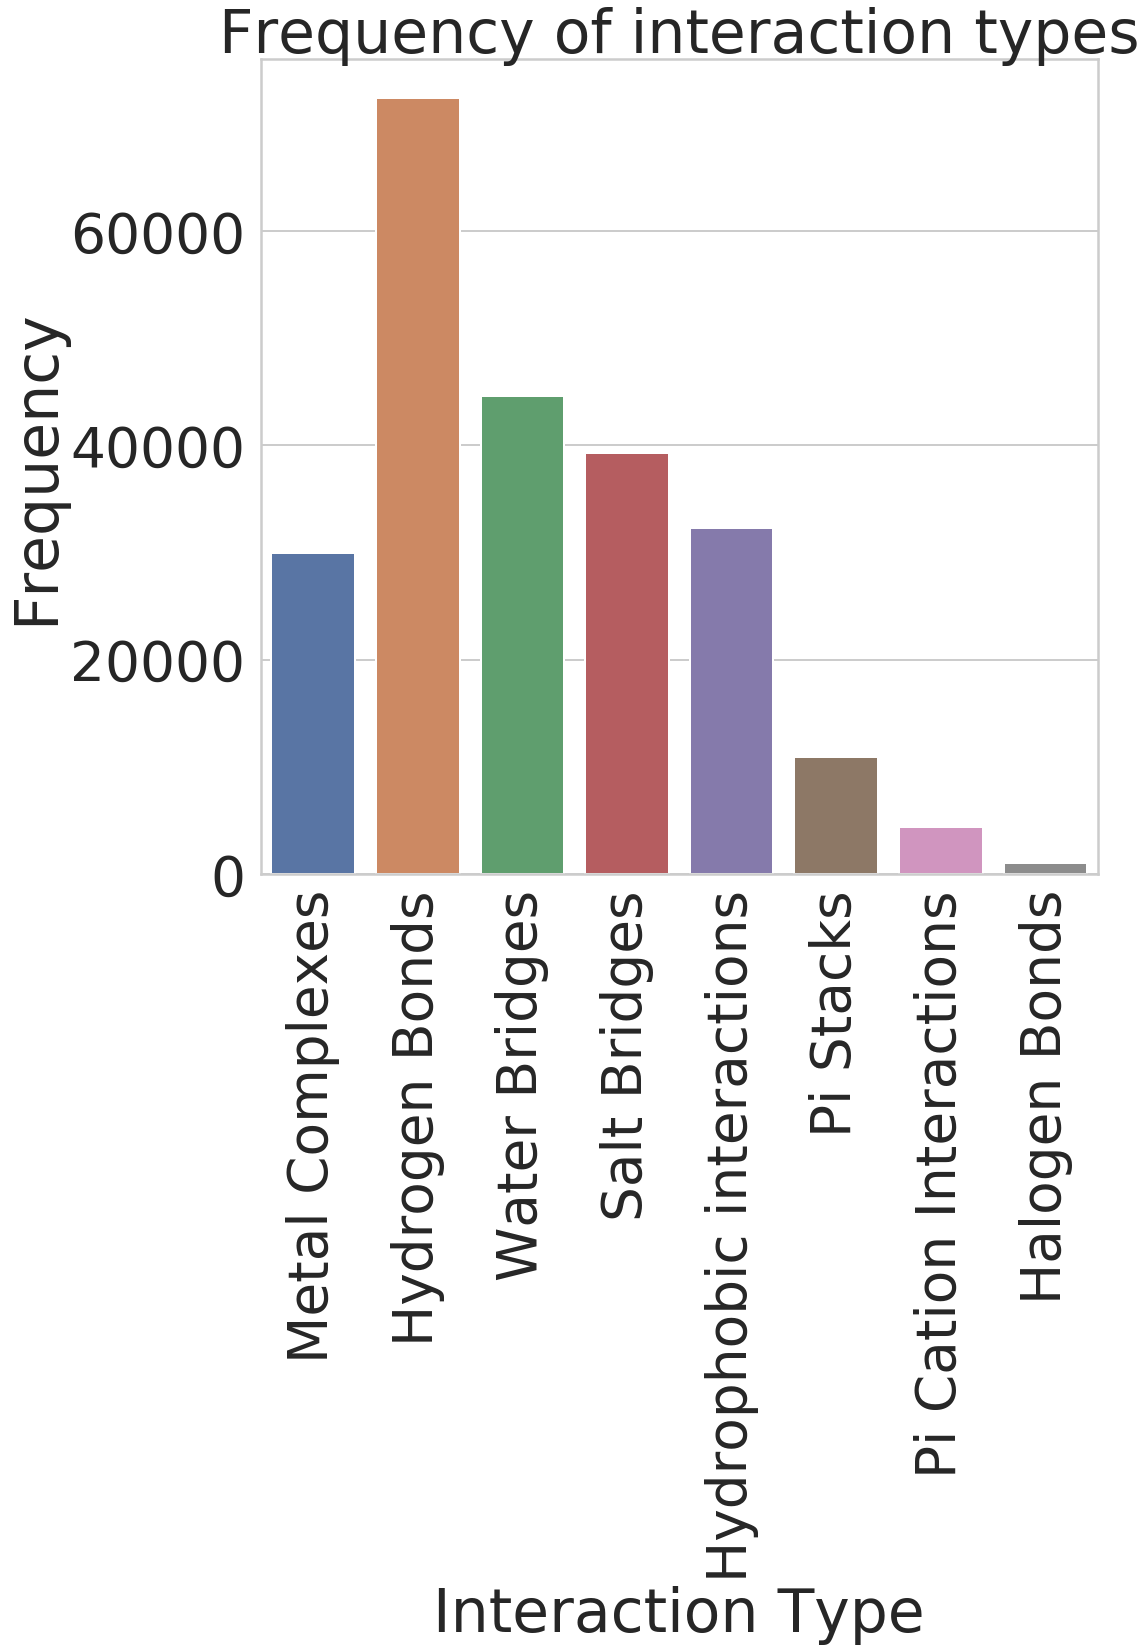

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.barplot(x='interaction', y='count', data=bar_data_df)
ax.set_title('Frequency of interaction types')
ax.set_xlabel('Interaction Type')
ax.set_ylabel('Frequency')
ax.set_xticklabels(labels=["Metal Complexes", 
                           "Hydrogen Bonds", 
                           "Water Bridges", 
                           "Salt Bridges", 
                           "Hydrophobic interactions", 
                           "Pi Stacks", 
                           "Pi Cation Interactions", 
                           "Halogen Bonds"], rotation=90)

In [12]:
# Identify aromatic rings
rings = []
for _file in tqdm_notebook(xml_files):
    # Get the pdbid
    pdbid = os.path.split(_file)[0]
    pdbid = pdbid.split('/')[2]
    if pdbid not in valid_pdbs: continue

    # Parse the xml file
    tree = ElementTree.parse(_file)
    root = tree.getroot()
    xmldict = XmlDictConfig(root)

    #_dict = {}
    if 'bindingsite' in xmldict.keys():
        d = xmldict['bindingsite']
        if 'lig_properties' in d.keys():
            d = d['lig_properties']
            rings.append([pdbid, d['num_aromatic_rings']])

In [13]:
aromatic_rings_df = pd.DataFrame.from_records(rings, columns=['pdbid', 'ring_count'])
aromatic_rings_df.head()
aromatic_rings_df.to_csv("aromatic_rings.csv", index=False)

In [14]:
aromatic_rings_df.head()

,pdbid,ring_count
0,pdb4bui,0
1,pdb6bqp,0
2,pdb2bu9,0
3,pdb3bmc,3
4,pdb5bjz,0


In [15]:
aromatic_rings_df = aromatic_rings_df[aromatic_rings_df.ring_count != '0']
len(aromatic_rings_df)

32159

In [16]:
aromatic_rings_df.describe()

,pdbid,ring_count
count,32159,32159
unique,32159,159
top,pdb1azq,2
freq,1,9872


In [17]:
data = []
# angles = defaultdict(list)
# distances = defaultdict(list)

for _file in tqdm_notebook(xml_files):
    # Get the pdbid
    pdbid = os.path.split(_file)[0]
    pdbid = pdbid.split('/')[2]
    if pdbid not in valid_pdbs: continue

    # Parse the xml file
    tree = ElementTree.parse(_file)
    root = tree.getroot()
    xmldict = XmlDictConfig(root)

    #_dict = {}
    if 'bindingsite' in xmldict.keys():
        d = xmldict['bindingsite']
        if 'interactions' in d.keys():
            d = d['interactions']
            
            # Check pi-interaction
            if d.get('pi_stacks', None) is not None:
                for val in d['pi_stacks'].values():
                    if isinstance(val, dict):
                        data.append([pdbid, 'pi_stacking', val['restype'], float(val['centdist']), float(val['angle']), val['type']])
#                         distances[val['restype']].append(float(val['centdist']))
#                         angles[val['restype']].append(float(val['angle']))
                        #_dict['pi'] = [val['resnr'], val['restype'], float(val['centdist']), float(val['angle']), val['type']]
                    if isinstance(val, list):
                        #_dict['pi'] = []
                        for item in val:
                            data.append([pdbid, 'pi_stacking', item['restype'], float(item['centdist']), float(item['angle']), item['type']])
#                             distances[item['restype']].append(float(item['centdist']))
#                             angles[item['restype']].append(float(item['angle']))
                            #_dict['pi'].append([item['resnr'], item['restype'], float(item['centdist']), float(item['angle']), item['type']])

            if d.get('pi_cation_interactions', None) is not None:
                for cation_interaction in d['pi_cation_interactions'].values():
                    if isinstance(cation_interaction, dict):
                        data.append([pdbid, 'pi_cation', cation_interaction['restype'], float(cation_interaction['dist']), None, None])
                        #_dict['pi_cation'] = [cation_interaction['resnr'], cation_interaction['restype'], float(cation_interaction['dist'])]
                    if isinstance(cation_interaction, list):
                        #_dict['pi_cation'] = []
                        for item in cation_interaction:
                            data.append([pdbid, 'pi_cation', item['restype'], float(item['dist']), None, None])
                            #_dict['pi_cation'].append([item['resnr'], item['restype'], float(item['dist'])])
    
    #if len(_dict) > 0: dictionary[pdbid] = _dict

In [22]:
data_df = pd.DataFrame.from_records(data, columns=['pdbid', 'int_type', 'residue', 'distance', 'angle', 'stack_type'])
print("Dataset length: {}".format(len(data_df)))
data_df.head()

Dataset length: 23412


,pdbid,int_type,residue,distance,angle,stack_type
0,pdb3bmc,pi_stacking,HIS,4.38,16.93,P
1,pdb6bw2,pi_stacking,PHE,5.25,80.37,T
2,pdb6bw2,pi_stacking,PHE,4.82,89.86,T
3,pdb1bzc,pi_stacking,TYR,3.92,21.79,P
4,pdb2bs0,pi_stacking,TYR,3.79,6.85,P


In [3]:
data_df = pd.read_csv('data.csv')
# data_df.to_csv('data.csv', index=False)
data_df = data_df[data_df.residue != 'CSM']

In [4]:
data_df.groupby('stack_type')['pdbid'].nunique()

stack_type
P    6456
T    5448
Name: pdbid, dtype: int64

In [5]:
data_df.groupby('int_type')['pdbid'].nunique()

int_type
pi_cation       4402
pi_stacking    10980
Name: pdbid, dtype: int64

In [6]:
data_df2 = data_df.fillna({'stack_type': 'C'})
data=data_df2.drop_duplicates(subset=['pdbid', 'stack_type']).groupby('stack_type').count()
data.reset_index(inplace=True)
data.head()

,stack_type,pdbid,int_type,residue,distance,angle
0,C,4402,4402,4402,4402,0
1,P,6456,6456,6456,6456,6456
2,T,5448,5448,5448,5448,5448


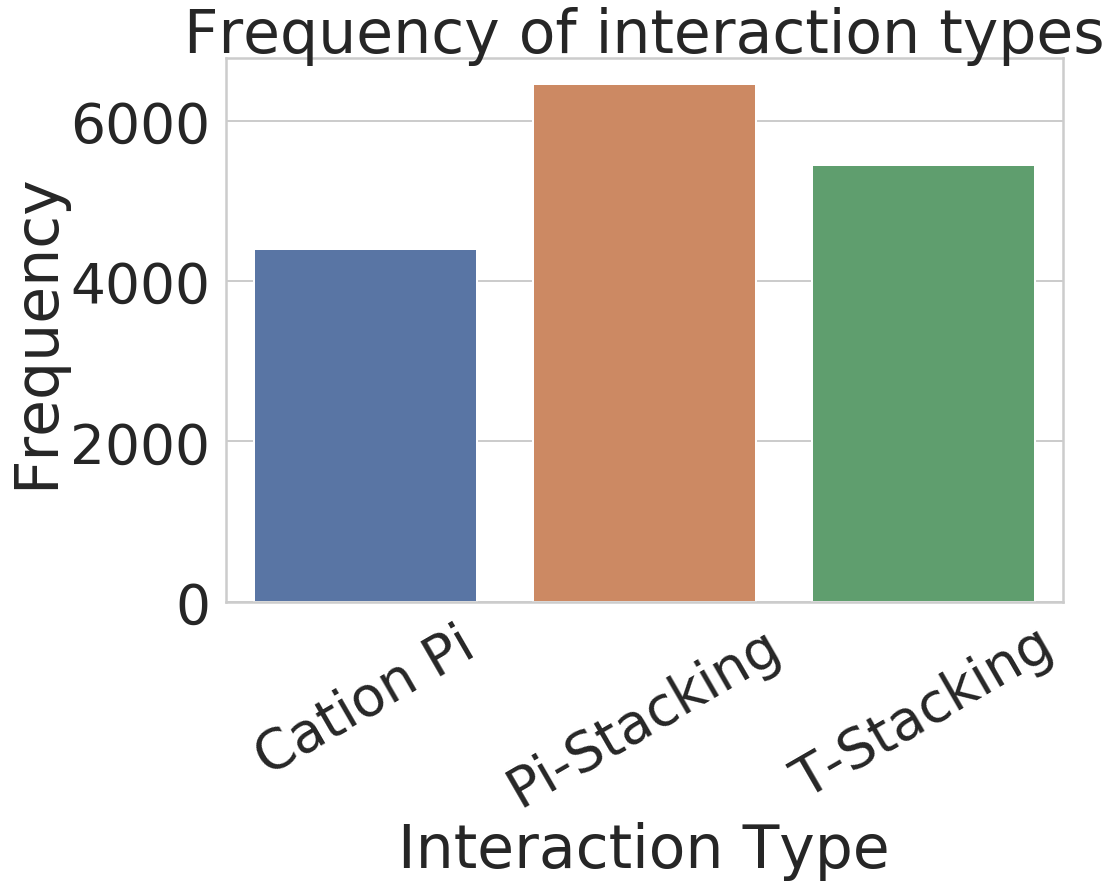

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='stack_type', y='pdbid', data=data)
ax.set_title('Frequency of interaction types')
ax.set_xlabel('Interaction Type')
ax.set_ylabel('Frequency')
ax.set_xticklabels(labels=["Cation Pi", "Pi-Stacking", "T-Stacking"], rotation=30)
fig.savefig('interaction_type_frequency.png', bbox_inches='tight', dpi=100)

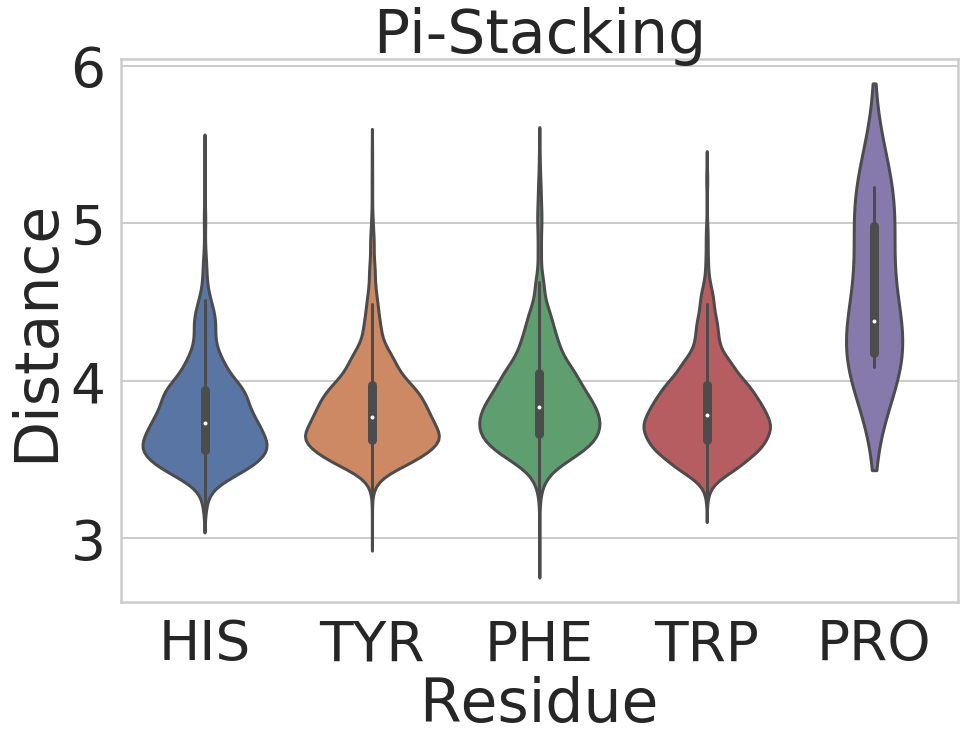

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="distance", data=data_df[data_df.stack_type=='P'])
ax.set_title('Pi-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_violin_p-stacking.png', bbox_inches='tight', dpi=100)

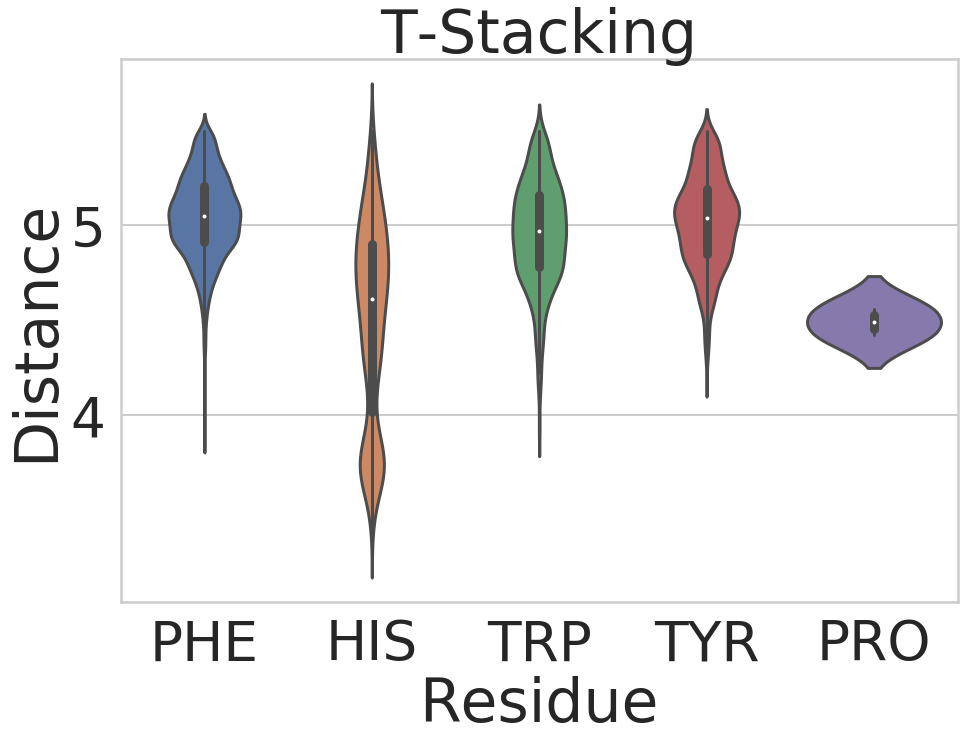

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="distance", data=data_df[data_df.stack_type=='T'])
ax.set_title('T-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_violin_t-stacking.png', bbox_inches='tight', dpi=100)

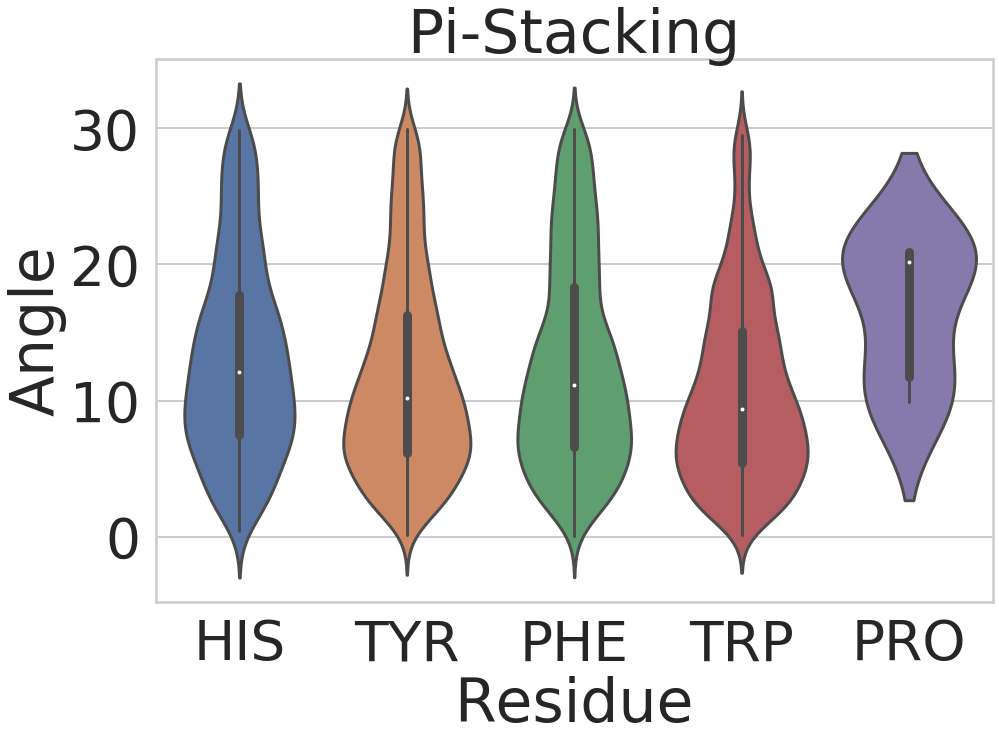

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="angle", data=data_df[data_df.stack_type=='P'])
ax.set_title('Pi-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Angle')
fig.savefig('angle_violin_p-stacking.png', bbox_inches='tight', dpi=100)

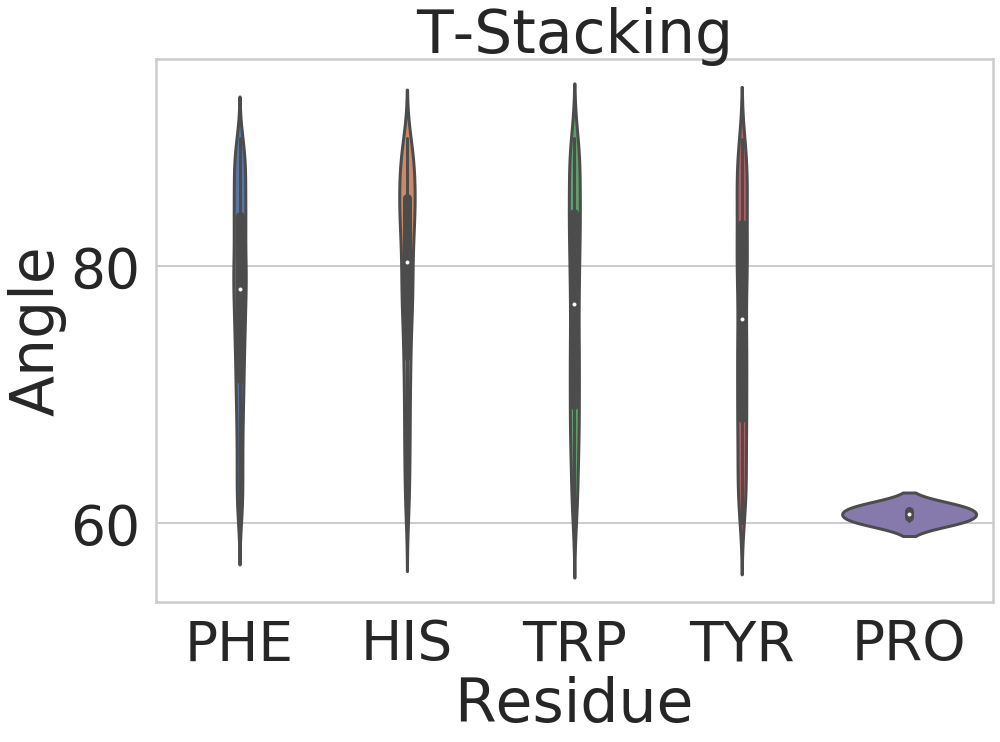

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="angle", data=data_df[data_df.stack_type=='T'])
ax.set_title('T-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Angle')
fig.savefig('angle_violin_t-stacking.png', bbox_inches='tight', dpi=100)

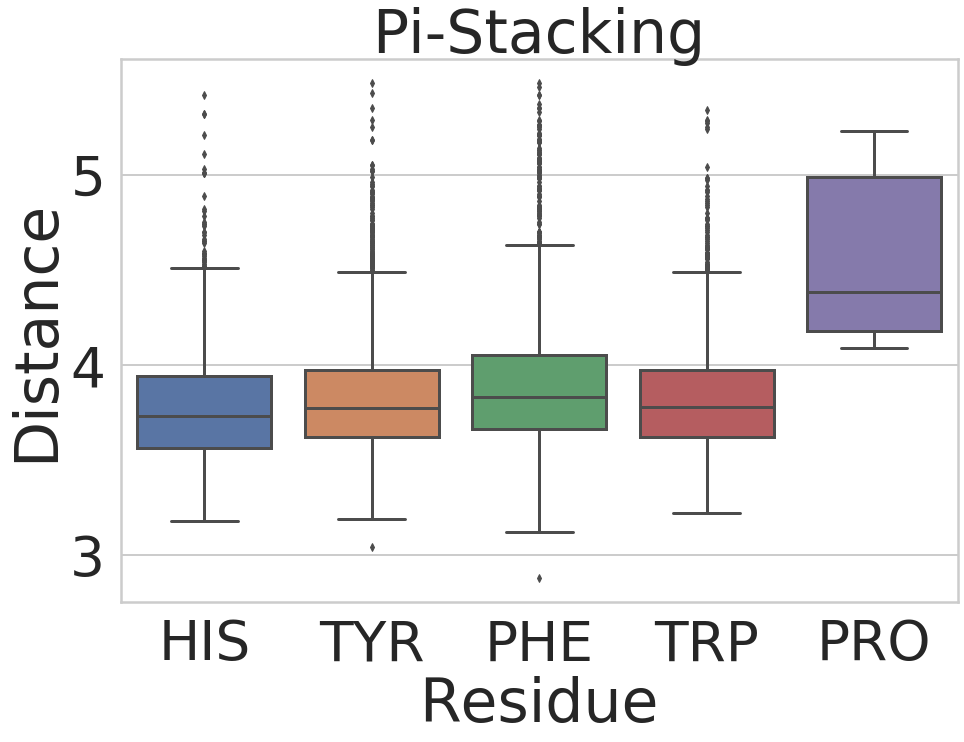

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="distance", data=data_df[data_df.stack_type=='P'])
ax.set_title('Pi-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_boxplot_p-stacking.png', bbox_inches='tight', dpi=100)

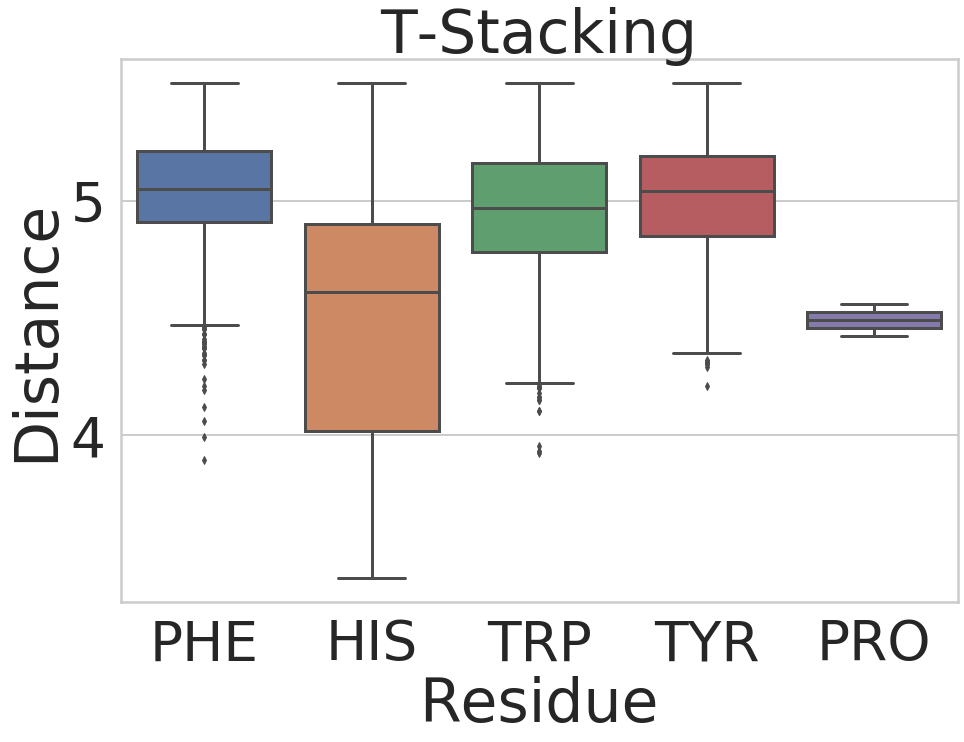

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="distance", data=data_df[data_df.stack_type=='T'])
ax.set_title('T-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_boxplot_t-stacking.png', bbox_inches='tight', dpi=100)

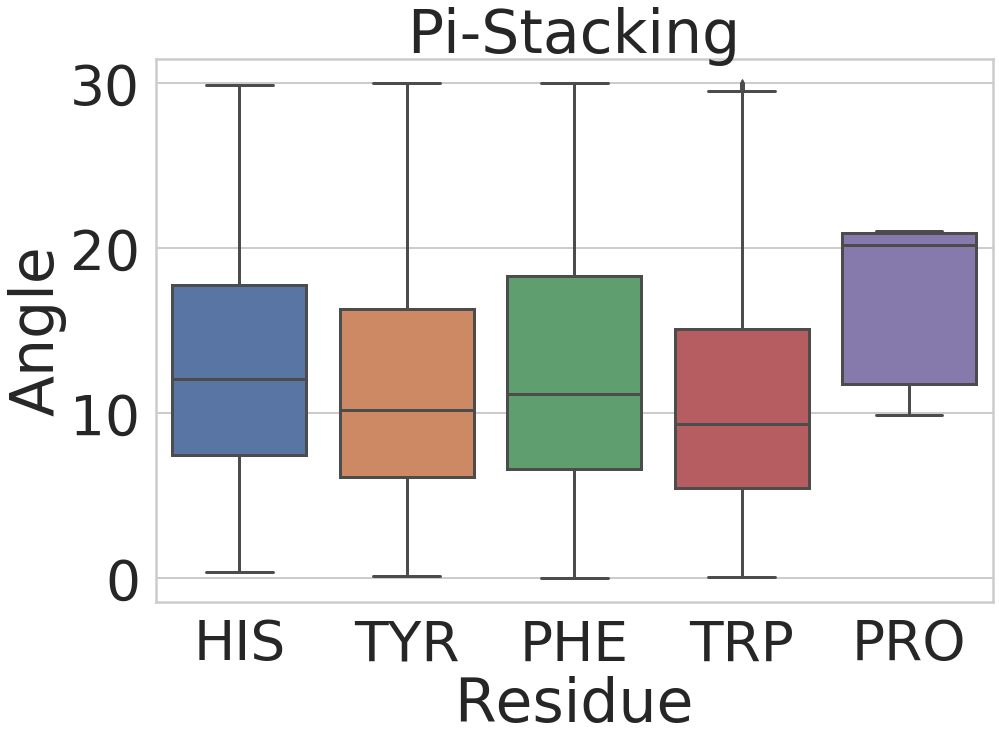

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="angle", data=data_df[data_df.stack_type=='P'])
ax.set_title('Pi-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Angle')
fig.savefig('angle_boxplot-p_stacking.png', bbox_inches='tight', dpi=100)

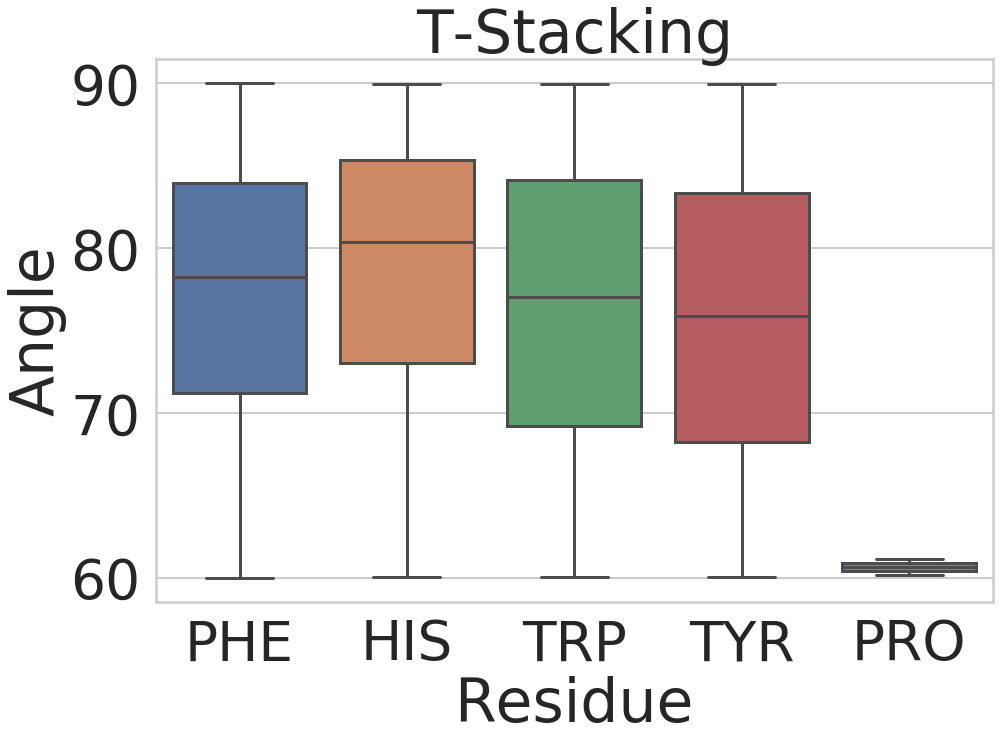

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="angle", data=data_df[data_df.stack_type=='T'])
ax.set_title('T-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Angle')
fig.savefig('angle_boxplot-t_stacking.png', bbox_inches='tight', dpi=100)

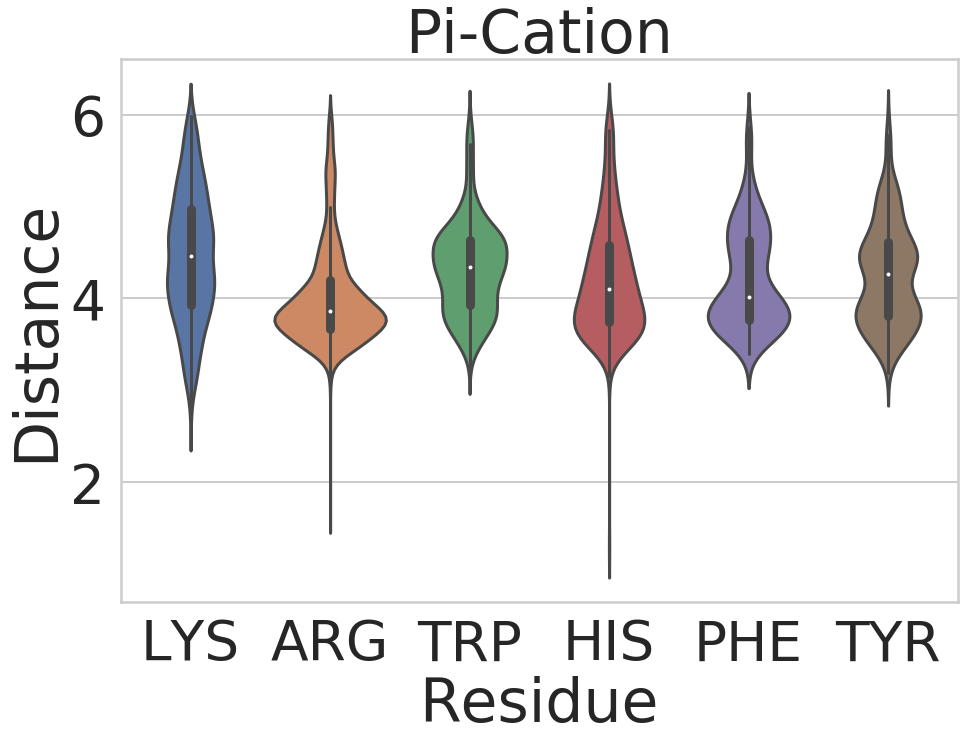

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="distance", data=data_df[data_df.int_type=='pi_cation'])
ax.set_title('Pi-Cation')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_violin_pi-cation.png', bbox_inches='tight', dpi=100)

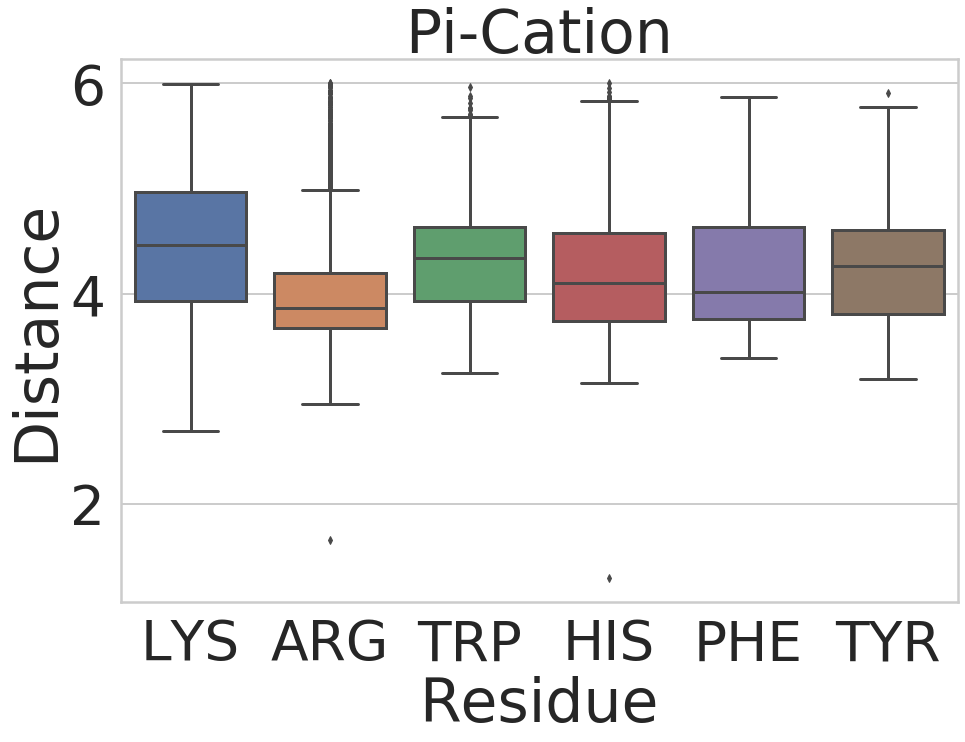

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="distance", data=data_df[data_df.int_type=='pi_cation'])
ax.set_title('Pi-Cation')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_boxplot_pi-cation.png', bbox_inches='tight', dpi=100)